# 50-Year Trend of Gold-Silver Ratio

## Executive Summary
In this study, I attempt to replicate the analysis performed by Belangp on his precious metal trading/stacking strategy based on the gold and silver ratio. The actual code development hasn't been linear, but I do manage to yield similar conclusion by going back and forth to tweak some parameters to achieve the best alignment results.

In conclusion, using an observation window of 10 years, we can observe a statistically significant linear relationship between **the annual log return of Silver relative to Gold** and **GSR**, with the line intersecting the x-axis at circa $GSR=66.0$.

Observations made during the optimisation/tweaking are:
- **Resampling approach**: When constructing the mont-end data from daily data, I have used month-end, monthly average and monthly median. Using average monthly data may provide slighly better RSQ value, but I've decided to stick with the month-end resampling approach.

- **OLS versus WLS**: Weighted Linear Squares (WLS) may provide a slightly better fit compared to Ordinary Least Squares (OLS), as greater variance can be observed in the lower GSR area. The increase in model complexity does not seem to add much value.

- **Outlier filtering**: I have also tried to exclude the 1% and 5% of the data from the head and tail regions. The improvement of the fitting does not appear to be consistent, so I'm not gonna apply this.

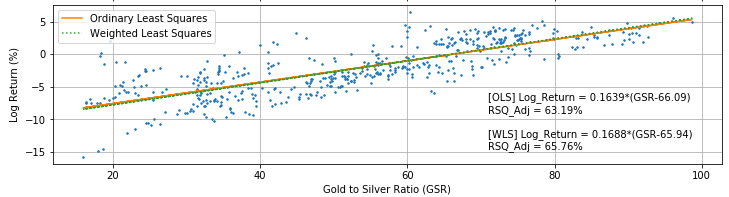

In [3]:
from IPython.display import display, Image
display(Image(filename='03_Output_Data/cover_pic_XAG_rel_return_vs_GSR.png'))

## Methodology

Assuming an observation window of $i$ months, the annual log return of each asset can be calculated as:
\begin{equation*}
R=\frac{1}{i}\cdot(R_{t+i}-R_{t})=\frac{1}{i}\cdot log(\frac{P_{t+i}}{P_{t}})
\end{equation*}

The log return of asset A relative to asset B is therefore:
\begin{equation*}
R_{rel}=R_{A} - R_{B}
\end{equation*}

We then try to regress the $R_{rel}$ against asset price ratio (e.g. GSR or Gold-to-Silver Ratio) with different model options.

## Reference
- GSR Valuation Update Time to Favor Silver (https://www.youtube.com/watch?v=C2EGjhcW-a0)

## Data Preprocessing

In [292]:
# Import libraries
import pandas as pd
import quandl
import math
import numpy as np
import scipy.stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from matplotlib import pyplot as plt
from scipy.stats import linregress
import os
%matplotlib notebook

# Set up folder directories
input_dir = "01_Raw_Data/"
procs_dir = "02_Processed_Data/"
output_dir = "03_Output_Data/"

In [2]:
start_date = "1900-01-01"
end_date = "2020-08-25"

### Prepare Price Data from Quandl
We are gonna leverage Quandl's free precious metal data for this analysis. Only run this module for periodic refresh as data are saved in the `\02_Processed_Data` folder.

#### Download Price Data for LBMA Gold
Uncomment the codes below to refresh the data.

In [14]:
# lbma_gold_df = quandl.get("LBMA/GOLD", authtoken="mph6fTrjas2wX3sBdYQn", start_date=start_date, end_date=end_date)
# lbma_gold_df['LBMA_Gold_USD'] = (lbma_gold_df['USD (AM)'] + lbma_gold_df['USD (PM)']) *0.5
# lbma_gold_df.index = pd.to_datetime(lbma_gold_df.index)
# pd.DataFrame(lbma_gold_df['LBMA_Gold_USD']).to_csv(procs_dir + 'lbma_gold_usd.csv')

#### Download Price Data for LBMA Silver
Uncomment the codes below to refresh the data.

In [13]:
# lbma_silver_df = quandl.get("LBMA/SILVER", authtoken="mph6fTrjas2wX3sBdYQn", start_date=start_date, end_date=end_date)
# lbma_silver_df.index = pd.to_datetime(lbma_silver_df.index)
# lbma_silver_df['LBMA_Silver_USD'] = lbma_silver_df['USD']
# pd.DataFrame(lbma_silver_df['LBMA_Silver_USD']).to_csv(procs_dir + 'lbma_silver_usd.csv')

#### Preprocess G&S Data
I append the downloaded gold and silver price data so that they're in the same dataframe.

In [8]:
# Read the downloaded data
lbma_gold_usd = pd.read_csv(procs_dir + 'lbma_gold_usd.csv', index_col=0, parse_dates=True)
lbma_silver_usd = pd.read_csv(procs_dir + 'lbma_silver_usd.csv', index_col=0, parse_dates=True)

# Resample to month-end (daily/weekly data will likely be too noisy)
lbma_gold_usd = lbma_gold_usd.resample('M').last()
lbma_silver_usd = lbma_silver_usd.resample('M').last()

# Append the gold and silver data
gs_comb_df = lbma_gold_usd.merge(lbma_silver_usd, how='outer', left_index=True, right_index=True)
gs_comb_df = gs_comb_df.dropna(how='any')

# Calculate Gold and Silver Ratio (GSR)
gs_comb_df['GSR'] = gs_comb_df['LBMA_Gold_USD'].divide(gs_comb_df['LBMA_Silver_USD'])

In [9]:
gs_comb_df.head()

,LBMA_Gold_USD,LBMA_Silver_USD,GSR
Date,,,
1968-04-30,39.100,2.397,16.312057
1968-05-31,41.975,2.483,16.904954
1968-06-30,40.925,2.502,16.356914
1968-07-31,38.875,2.285,17.013129
1968-08-31,39.825,2.239,17.786958


Good stuff. We have data available from 30/04/1968 for both gold and silver.

### Calculate Periodic Return
For this analysis, we look at the horizon of every 10 years. For a rotational window of 10 years, we are going to do the following:
- Calculate return (both percentage and log) individually for gold and silver
- Calculate the return of silver relative to gold
- Append the GSR as at the **beginning** of each observation window

Since the data has been resampled to monthly, we will calculate the return every 120 months (i.e. 10 years).

In [10]:
# Calculate individual percentage return
gs_return_df = gs_comb_df[['LBMA_Gold_USD', 'LBMA_Silver_USD']].pct_change(periods=120).dropna()
gs_return_df.columns = ['return_gold', 'return_silver']

# Calculate silver return relative to gold 
gs_return_df['return_rel'] = gs_return_df['return_silver'] - gs_return_df['return_gold']

# Calculate individual log return
gs_log_return_df = np.log(gs_comb_df[['LBMA_Gold_USD', 'LBMA_Silver_USD']]).diff(periods=120).dropna()
gs_log_return_df.columns = ['log_return_gold', 'log_return_silver']

# Annualise the log return
gs_log_return_df = gs_log_return_df / (120/12) * 100

# Calculate silver return relative to gold 
gs_log_return_df['log_return_rel'] = gs_log_return_df['log_return_silver'] - gs_log_return_df['log_return_gold']

In [11]:
gs_return_df.head()
gs_log_return_df.head()

,log_return_gold,log_return_silver,log_return_rel
Date,,,
1978-04-30,14.721729,7.348199,-7.373530
1978-05-31,14.807108,7.890796,-6.916312
1978-06-30,14.984279,7.462673,-7.521605
1978-07-31,16.358387,8.915675,-7.442713
1978-08-31,16.530432,9.043393,-7.487039


Now for each 10 years' return of gold and silver, we need to append the GSR at the beginning of each observation window. Take, for instance, a 10-year observation window from **30/04/1968** to **30/04/1978** (inclusive):
- Gold YoY return = 335.87%, silver YoY return = 108.51%, relative YoY return = -227.36%
- GSR = 16.31 as at 30/04/1968

Note that the GSR on 30/04/1968, instead of 30/04/1978, is used here.

In [12]:
# Shift the column by 120 months backward, so that the GSR at the beginning of the 10-year observation window
# will be mapped to the observation window end date
gs_return_df['GSR_start'] = gs_comb_df['GSR'].shift(periods=120)
gs_return_df.head()

gs_log_return_df['GSR_start'] = gs_comb_df['GSR'].shift(periods=120)
gs_log_return_df.head()

,log_return_gold,log_return_silver,log_return_rel,GSR_start
Date,,,,
1978-04-30,14.721729,7.348199,-7.373530,16.312057
1978-05-31,14.807108,7.890796,-6.916312,16.904954
1978-06-30,14.984279,7.462673,-7.521605,16.356914
1978-07-31,16.358387,8.915675,-7.442713,17.013129
1978-08-31,16.530432,9.043393,-7.487039,17.786958


## Regression Model Analysis
Our data is now prepared and handsome, so we may proceed with our actual analysis.
### Initial Attempt (Percentage Return vs Log Return)
#### Percentage Return

In [13]:
# Duplicate the df for the study
gs_return_df1 = gs_return_df

# Here x is GSR and y is the relative return
X1 = gs_return_df1['GSR_start']
Y1 = gs_return_df1['return_rel']

# Fit the line regression model
model1 = sm.OLS(Y1, sm.add_constant(X1))
results1 = model1.fit()
print(results1.summary())

# Prepare result text
ax1_text = "Pct_Return = {:.4f}*(GSR{:.2f})\nRSQ_Adj = {:.2f}%" \
            .format(results1.params.GSR_start, results1.params.const/results1.params.GSR_start,
                    results1.rsquared_adj*100)
print(ax1_text)

                            OLS Regression Results                            
Dep. Variable:             return_rel   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     310.9
Date:                Wed, 26 Aug 2020   Prob (F-statistic):           1.30e-54
Time:                        16:05:29   Log-Likelihood:                -791.35
No. Observations:                 509   AIC:                             1587.
Df Residuals:                     507   BIC:                             1595.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.9417      0.150    -19.645      0.0

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


#### Log Return (OLS)

In [14]:
# Filter on the date
gs_log_return_df1 = gs_log_return_df#[gs_log_return_df.index <= "2017-06-30"]

# Here x is GSR and y is the relative return
X1b = gs_log_return_df1['GSR_start']
Y1b = gs_log_return_df1['log_return_rel']

# Fit the line regression model
model1b = sm.OLS(Y1b, sm.add_constant(X1b))
results1b = model1b.fit()
print(results1b.summary())

# Prepare result text
ax1b_text = "[OLS] Log_Return = {:.4f}*(GSR{:.2f})\nRSQ_Adj = {:.2f}%" \
            .format(results1b.params.GSR_start, results1b.params.const/results1b.params.GSR_start,
                    results1b.rsquared_adj*100)
print(ax1b_text)

                            OLS Regression Results                            
Dep. Variable:         log_return_rel   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     873.0
Date:                Wed, 26 Aug 2020   Prob (F-statistic):          2.57e-112
Time:                        16:05:31   Log-Likelihood:                -1174.0
No. Observations:                 509   AIC:                             2352.
Df Residuals:                     507   BIC:                             2360.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8354      0.318    -34.119      0.0

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


#### Log Return (WLS)
Interestingly, the variance in y in the lower GSR range is rather wide contrast to that in the higher GSR range. Here we consider applying a weight function to accomodate this.

In [42]:
# Filter on the date
gs_log_return_df1 = gs_log_return_df#[gs_log_return_df.index <= "2017-06-30"]

# Here x is GSR and y is the relative return
X1b = gs_log_return_df1['GSR_start']
Y1b = gs_log_return_df1['log_return_rel']

# Fit the line regression model
model1c = sm.WLS(Y1b, sm.add_constant(X1b), weights=X1b)
results1c = model1c.fit()
print(results1c.summary())

# Prepare result text
ax1c_text = "[WLS] Log_Return = {:.4f}*(GSR{:.2f})\nRSQ_Adj = {:.2f}%" \
            .format(results1c.params.GSR_start, results1c.params.const/results1c.params.GSR_start,
                    results1c.rsquared_adj*100)
print(ax1c_text)

                            WLS Regression Results                            
Dep. Variable:         log_return_rel   R-squared:                       0.658
Model:                            WLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     976.5
Date:                Wed, 26 Aug 2020   Prob (F-statistic):          2.75e-120
Time:                        16:15:14   Log-Likelihood:                -1141.7
No. Observations:                 509   AIC:                             2287.
Df Residuals:                     507   BIC:                             2296.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1308      0.343    -32.466      0.0

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


#### Fitting Analysis

<IPython.core.display.Javascript object>


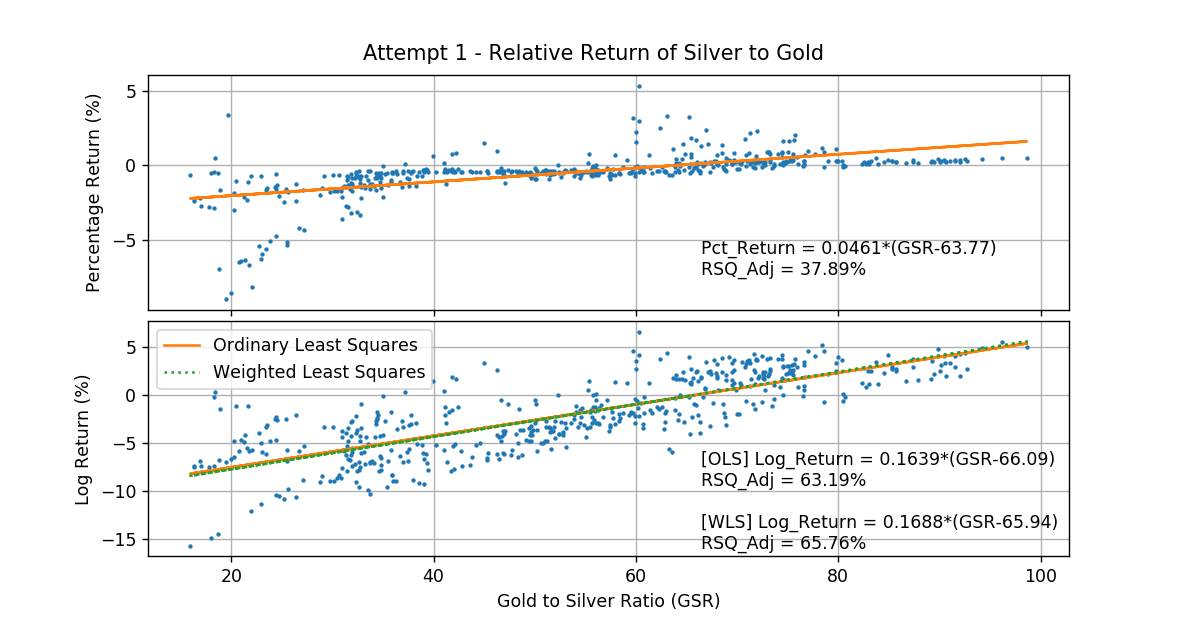

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9.5, 5), sharex=True)

# Percentage return
ax1.plot(X1, Y1, 'o', markersize=1.5)
ax1.plot(X1, results1.params.GSR_start * X1 + results1.params.const)
ax1.set_ylabel('Percentage Return (%)')
ax1.text(0.6, 0.3, ax1_text, horizontalalignment='left', verticalalignment='top',
     transform = ax1.transAxes)
ax1.grid()

# Log return
ax2.plot(X1b, Y1b, 'o', markersize=1.5)
l1, = ax2.plot(X1b, results1b.params.GSR_start * X1b + results1b.params.const, '')
l2, = ax2.plot(X1b, results1c.params.GSR_start * X1b + results1c.params.const, ':')
ax2.legend([l1, l2], ['Ordinary Least Squares', 'Weighted Least Squares'],loc="upper left")
ax2.set_xlabel('Gold to Silver Ratio (GSR)'), ax2.set_ylabel('Log Return (%)')
ax2.text(0.6, 0.45, ax1b_text + "\n\n" + ax1c_text,
         horizontalalignment='left', verticalalignment='top', transform = ax2.transAxes)
ax2.grid()

fig.suptitle("Attempt 1 - Relative Return of Silver to Gold", y=0.93)
plt.subplots_adjust(hspace=.05)
plt.show()

From the comparison from above, we can see that using log return provides a better fitting results. This is not a surprise as it is a typical way to analyse time series data.
#### Residual Analysis

<IPython.core.display.Javascript object>


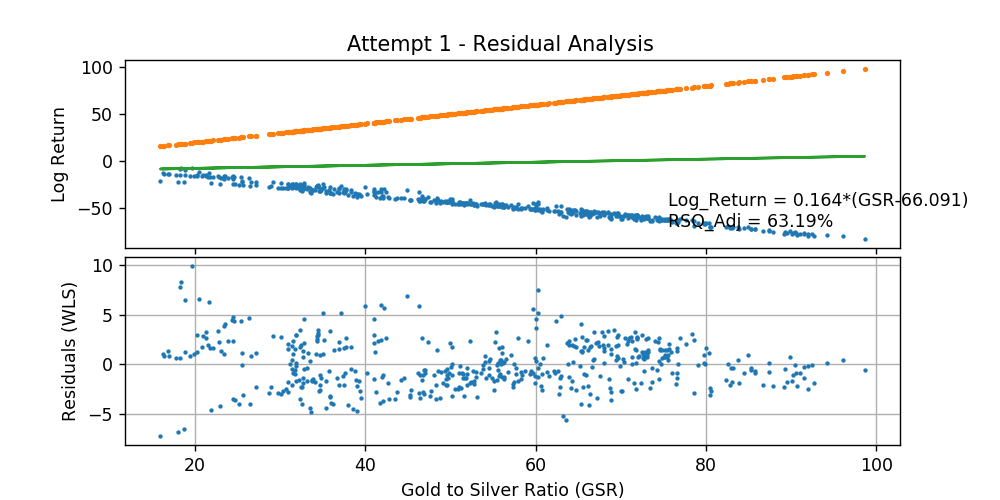

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4), sharex=True)

# Percentage return
ax1.plot(X1b, Y1b - results1b.params.GSR_start - X1b - results1b.params.const, 'o', markersize=1.5)
ax1.set_ylabel('Residuals (OLS)')
ax1.grid()

# Log return
ax2.plot(X1b, Y1b - results1c.params.GSR_start * X1b - results1c.params.const, 'o', markersize=1.5)
ax2.set_xlabel('Gold to Silver Ratio (GSR)'), ax2.set_ylabel('Residuals (WLS)')
ax2.grid()

fig.suptitle("Attempt 1 - Residual Analysis", y=0.93)
plt.subplots_adjust(hspace=.05)
plt.show()

### Second Attempt (Outlier Filter)

In this attempt, I will apply a percentile filter to take out the extreme (1%) observations from both ends, using only the log return.

In [338]:
# Take out observations within 1% of either tails
filt_alpha = 0.01
filt_cond = ( gs_log_return_df.log_return_rel <= np.percentile(gs_log_return_df.log_return_rel, (1-filt_alpha)*100) ) &\
            ( gs_log_return_df.log_return_rel >= np.percentile(gs_log_return_df.log_return_rel, filt_alpha*100))
gs_log_return_df2 = gs_log_return_df[filt_cond]

# Here x is GSR and y is the relative return
X2 = gs_log_return_df2['GSR_start']
Y2 = gs_log_return_df2['log_return_rel']

# Fit the line regression model
model2 = sm.WLS(Y2, sm.add_constant(X2), weights=X2)
results2 = model2.fit()
print(results2.summary())

# Prepare result text
ax2_text = "Log_Return = {:.3f}*(GSR{:.3f})\nRSQ_Adj = {:.2f}%" \
            .format(results2.params.GSR_start, results2.params.const/results2.params.GSR_start,
                    results2.rsquared_adj*100)
print(ax2_text)

                            WLS Regression Results                            
Dep. Variable:         log_return_rel   R-squared:                       0.649
Model:                            WLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     914.0
Date:                Wed, 26 Aug 2020   Prob (F-statistic):          1.61e-114
Time:                        11:10:08   Log-Likelihood:                -1097.6
No. Observations:                 497   AIC:                             2199.
Df Residuals:                     495   BIC:                             2208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8603      0.342    -31.773      0.0

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


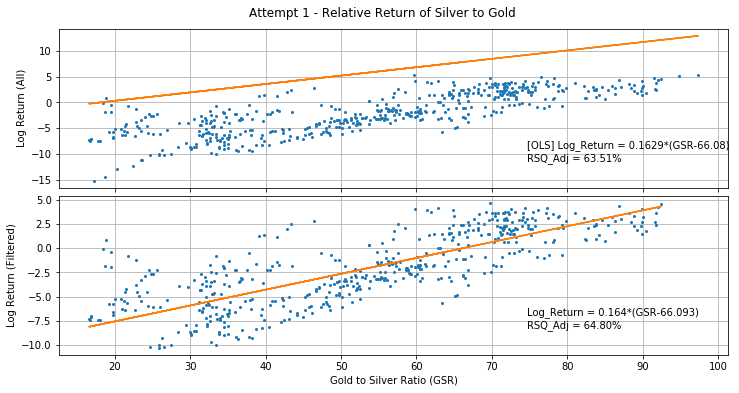

In [339]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Log return (no filter)
ax1.plot(X1b, Y1b, 'o', markersize=2)
ax1.plot(X1b, results1b.params.GSR_start * X1b + results1.params.const)
ax1.set_ylabel('Log Return (All)')
ax1.text(0.7, 0.3, ax1b_text, horizontalalignment='left', verticalalignment='top',
     transform = ax1.transAxes)
ax1.grid()

# Log return (with filter)
ax2.plot(X2, Y2, 'o', markersize=2)
ax2.plot(X2, results2.params.GSR_start * X2 + results2.params.const)
ax2.set_xlabel('Gold to Silver Ratio (GSR)'), ax2.set_ylabel('Log Return (Filtered)')
ax2.text(0.7, 0.3, ax2_text, horizontalalignment='left', verticalalignment='top',
     transform = ax2.transAxes)
ax2.grid()

fig.suptitle("Attempt 1 - Relative Return of Silver to Gold", y=0.93)
plt.subplots_adjust(hspace=.05)
plt.show()

## Time Horizon Analysis
Now that we have some rough ideas of the relationship between the relative log return of silver and GSR with a time horizon of 10 years, I'd like to repeat the analysis with different horizons.

To make the work simpler, I'll first wrap the code up into a class so that it can get repeated later.

In [324]:
class RatioAnalysis():
    def __init(self):
        self.asset_a = tuple()
        self.asset_b = tuple()
        self.month_horizon = None
        self.asset_df = pd.DataFrame()
        self.asset_return_df = pd.DataFrame()
        self.asset_ratio_name = None
        self.ratio_asset_a_as_base = None
        self.return_asset_a_as_base = None
        self.model_result = None
        self.model_df_filt = None
        self.__var_X = None
        self.__var_Y = None
        self.__plot_text = None
        
    def read_price_dict(self, asset_a=tuple(), asset_b=tuple(), asset_a_as_base=True):
        """Read in the monthly prices of two different assets. These are to be provided as a tuple
        ('asset_name', asset_price_df). Two asset dfs must have date index and will be merged by indices.
        By default, asset A is treated as base.
        """
        
        # Merge asset prices
        asset_df = asset_a[1].merge(asset_b[1], how='outer', left_index=True, right_index=True)\
                             .dropna(how='any')
        
        # Override column names
        asset_df.columns = [asset_a[0], asset_b[0]]
        
        # Calculate asset ratios relative to base
        if(asset_a_as_base):
            self.asset_ratio_name = asset_b[0] + "-to-" + asset_a[0]
            asset_df[self.asset_ratio_name] = asset_df.iloc[:, 1].divide(asset_df.iloc[:, 0])
        else:
            self.asset_ratio_name = asset_a[0] + "-to-" + asset_b[0]
            asset_df[self.asset_ratio_name] = asset_df.iloc[:, 0].divide(asset_df.iloc[:, 1])
            
        # Update class attributes
        self.asset_a = asset_a
        self.asset_b = asset_b
        self.ratio_asset_a_as_base = asset_a_as_base
        self.asset_df = asset_df

    def compute_log_return(self, month_horizon=1, asset_a_as_base=True):
        """Calculate the log return of the two assets. Month horizon represents resampling period
        (observation window).
        """
        
        # Re-direct pointer so that it's easier to reference
        asset_df = self.asset_df
        
        # Calculate individual log return
        log_return_df = np.log(asset_df.iloc[:, [0, 1]]).diff(periods=month_horizon).dropna()
        log_return_df.columns = ['log_return_' + self.asset_a[0], 'log_return_' + self.asset_b[0]]

        # Annualise the log return
        log_return_df = log_return_df / (month_horizon/12) * 100

        # Calculate silver return relative to gold
        if(asset_a_as_base):
            log_return_df['log_return_rel'] = log_return_df.iloc[:, 1] - log_return_df.iloc[:, 0]
        else:
            log_return_df['log_return_rel'] = log_return_df.iloc[:, 0] - log_return_df.iloc[:, 1]
        
        # Append the asset price ratio
        log_return_df[self.asset_ratio_name] = asset_df.iloc[:, 2].shift(periods=month_horizon)
        
        # Update class attributes
        self.month_horizon = month_horizon
        self.asset_return_df = log_return_df
        self.return_asset_a_as_base = asset_a_as_base
        self.model_df = log_return_df[[self.asset_ratio_name, 'log_return_rel']]
    
    def run_regression(self, filt_alpha=0.0, weights=None, print_result=True):
        
        # Re-direct pointer so that it's easier to reference
        model_df = self.model_df
        
        # Filter out extreme outliers at head and tail regions
        filt_cond = ( model_df.log_return_rel <= np.percentile(model_df.log_return_rel, (1-filt_alpha)*100) ) &\
                    ( model_df.log_return_rel >= np.percentile(model_df.log_return_rel, filt_alpha*100))
        model_df2 = model_df[filt_cond]

        # Here x is GSR and y is the relative return
        X = model_df2.iloc[:, 0]
        Y = model_df2.iloc[:, 1]

        # Fit the line regression model
        model = sm.OLS(Y, sm.add_constant(X))
        results = model.fit()

        # Prepare result text
        text = "Log_Return = {:.3f}*(GSR{:.3f})\nRSQ_Adj = {:.2f}%" \
                .format(results.params[1], results.params.const/results.params[1],
                        results.rsquared_adj*100)
        if(print_result):
            print(results.summary())
        else:
            print(text)

        # Update class attributes
        self.model_result = results
        self.__var_X = X
        self.__var_Y = Y
        self.__plot_text = text
        self.model_df_filt = model_df2
        
        return(results)
    
    def plot_results(self):
        
        results = self.model_result
        
        # Initialise canvas
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

        # Plot confidence interval
#         st, data, ss2 = summary_table(results, alpha=0.05)
#         fittedvalues = data[:, 2]
#         predict_mean_se  = data[:, 3]
#         predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
#         predict_ci_low, predict_ci_upp = data[:, 6:8].T
#         ax1.plot(self.__var_X, predict_ci_low, ':', lw=1, color='xkcd:azure')
#         ax1.plot(self.__var_X, predict_ci_upp, ':', lw=1, color='xkcd:azure')
#         ax1.fill_between(self.__var_X, predict_ci_low, predict_ci_upp, color='xkcd:azure', alpha='0.2')
        
        # Figure 1 - Fitted lines vs raw data
        p1, = ax1.plot(self.model_df.iloc[:, 0], self.model_df.iloc[:, 1], 'o', color='coral',
                       markersize=2, alpha=0.5)
        p2, = ax1.plot(self.__var_X, self.__var_Y, 'o', color='xkcd:azure', markersize=2, alpha=0.7)
        ax1.plot(self.__var_X, results.params[1] * self.__var_X + results.params.const, alpha=0.9)
        ax1.legend([p1, p2], ['Filtered Outliers', 'Modelled Observations'], loc='lower right')
        ax1.set_ylabel('Relative Log Return (%)')
        ax1.grid()
        
        # Figure 2 - Residuals
        ax2.plot(self.__var_X, self.__var_Y - results.params[1] * self.__var_X - results.params.const,
                 'o', color='xkcd:azure', markersize=2, alpha=0.7)
        ax2.set_ylabel('Residuals')
        ax2.set_xlabel(self.asset_ratio_name + ' Ratio')
        ax2.text(0.6, 0.9, self.__plot_text, horizontalalignment='left', verticalalignment='top',
                 transform = ax2.transAxes)
        ax2.grid()

        if(self.return_asset_a_as_base):
            fig.suptitle("Log Return of {} Relative to {}\n(Time Horizon = {} Months)"\
               .format(self.asset_b[0], self.asset_a[0], self.month_horizon), y=0.97)
        else:
            fig.suptitle("Log Return of {} Relative to {}\n(Time Horizon = {} Months)"\
               .format(self.asset_a[0], self.asset_b[0], self.month_horizon), y=0.97)
        plt.subplots_adjust(hspace=.05)
        plt.show()

### 15 Years

                            OLS Regression Results                            
Dep. Variable:         log_return_rel   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     624.5
Date:                Wed, 26 Aug 2020   Prob (F-statistic):           2.02e-71
Time:                        20:40:39   Log-Likelihood:                -227.26
No. Observations:                 265   AIC:                             458.5
Df Residuals:                     263   BIC:                             465.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.8871      0.096    -40.

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<IPython.core.display.Javascript object>


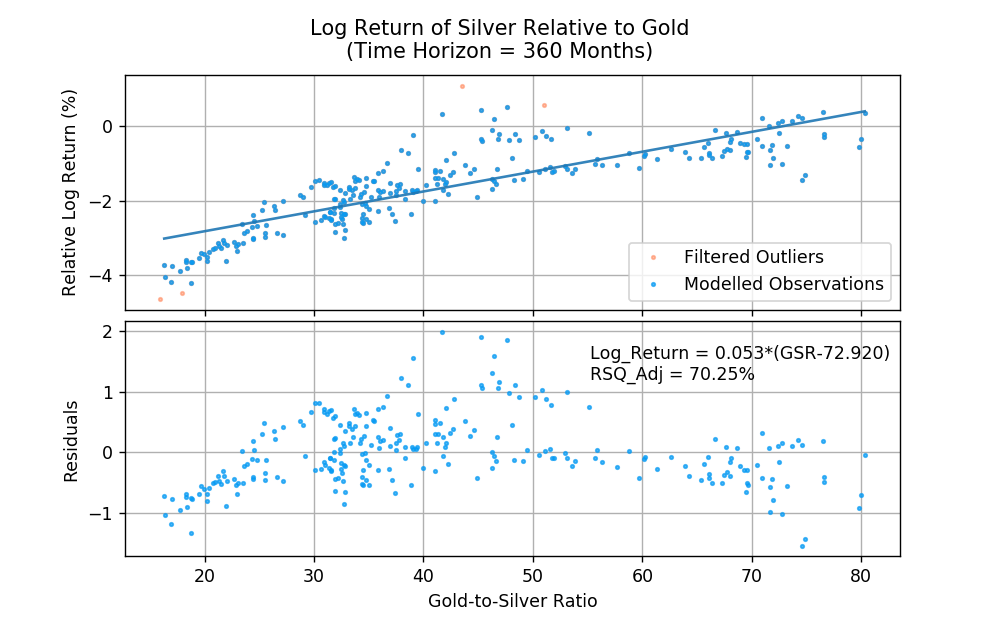

In [339]:
# Run instance
analy_GSR0 = RatioAnalysis()
analy_GSR0.read_price_dict(asset_a = ('Gold', lbma_gold_usd), asset_b = ('Silver', lbma_silver_usd),
                          asset_a_as_base=False)
analy_GSR0.compute_log_return(month_horizon=360)
analy_GSR0.run_regression(print_result=True, filt_alpha=0.005)
analy_GSR0.plot_results()

### 10 Years

                            OLS Regression Results                            
Dep. Variable:         log_return_rel   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     846.6
Date:                Wed, 26 Aug 2020   Prob (F-statistic):          1.01e-109
Time:                        20:35:57   Log-Likelihood:                -1143.9
No. Observations:                 503   AIC:                             2292.
Df Residuals:                     501   BIC:                             2300.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -10.5483      0.313    -33.

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<IPython.core.display.Javascript object>


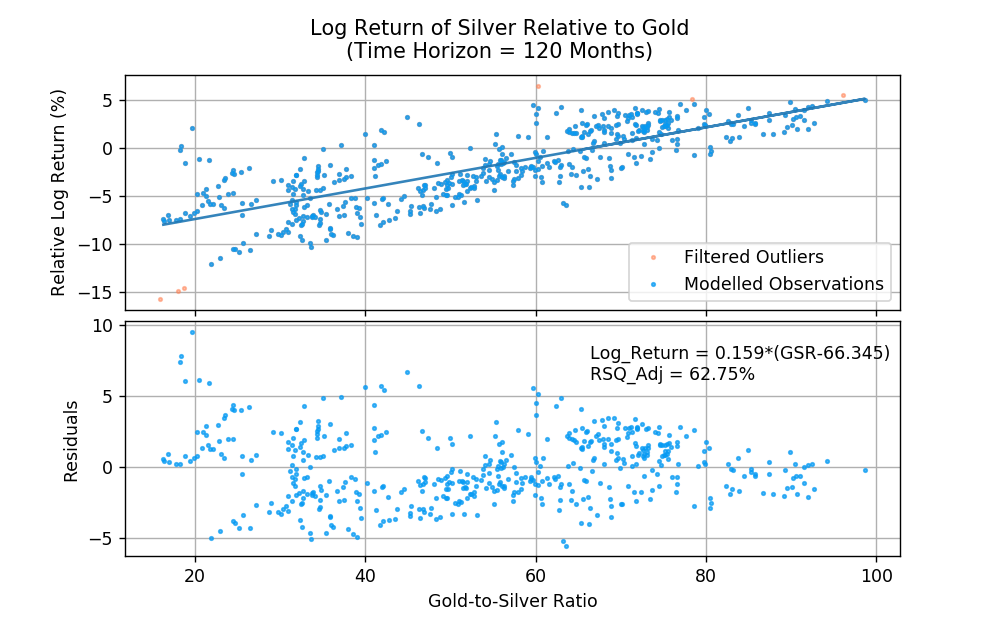

In [328]:
# Run instance
analy_GSR1 = RatioAnalysis()
analy_GSR1.read_price_dict(asset_a = ('Gold', lbma_gold_usd), asset_b = ('Silver', lbma_silver_usd),
                          asset_a_as_base=False)
analy_GSR1.compute_log_return(month_horizon=120)
analy_GSR1.run_regression(print_result=True, filt_alpha=0.005)
analy_GSR1.plot_results()

### 5 Years

                            OLS Regression Results                            
Dep. Variable:         log_return_rel   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     359.3
Date:                Wed, 26 Aug 2020   Prob (F-statistic):           2.68e-62
Time:                        20:35:49   Log-Likelihood:                -1667.0
No. Observations:                 563   AIC:                             3338.
Df Residuals:                     561   BIC:                             3347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -13.4275      0.611    -21.

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<IPython.core.display.Javascript object>


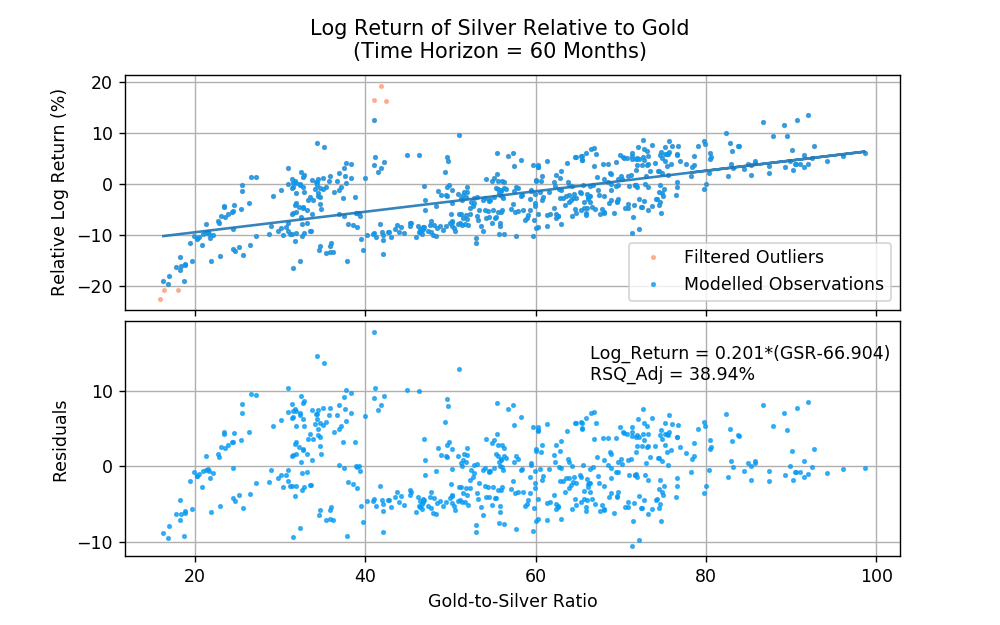

In [327]:
# Run instance
analy_GSR2 = RatioAnalysis()
analy_GSR2.read_price_dict(asset_a = ('Gold', lbma_gold_usd), asset_b = ('Silver', lbma_silver_usd),
                          asset_a_as_base=False)
analy_GSR2.compute_log_return(month_horizon=60)
analy_GSR2.run_regression(print_result=True, filt_alpha=0.005)
analy_GSR2.plot_results()

### 2 Years

                            OLS Regression Results                            
Dep. Variable:         log_return_rel   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     145.7
Date:                Wed, 26 Aug 2020   Prob (F-statistic):           3.66e-30
Time:                        20:36:21   Log-Likelihood:                -2246.0
No. Observations:                 597   AIC:                             4496.
Df Residuals:                     595   BIC:                             4505.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -18.2751      1.346    -13.

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<IPython.core.display.Javascript object>


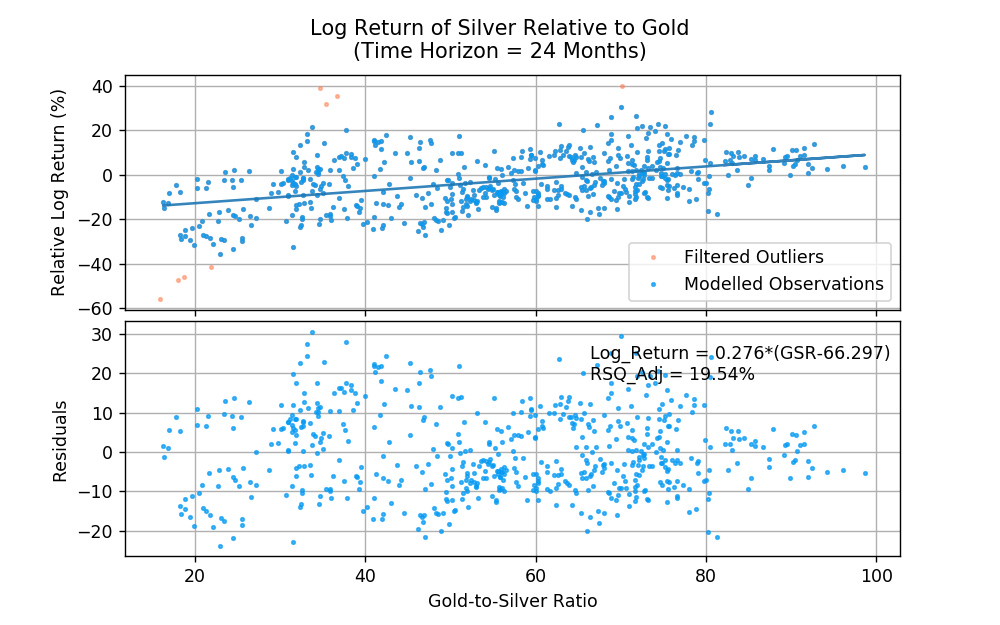

In [330]:
# Run instance
analy_GSR3 = RatioAnalysis()
analy_GSR3.read_price_dict(asset_a = ('Gold', lbma_gold_usd), asset_b = ('Silver', lbma_silver_usd),
                          asset_a_as_base=False)
analy_GSR3.compute_log_return(month_horizon=24)
analy_GSR3.run_regression(print_result=True, filt_alpha=0.005)
analy_GSR3.plot_results()

### 1 Year

                            OLS Regression Results                            
Dep. Variable:         log_return_rel   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     69.63
Date:                Wed, 26 Aug 2020   Prob (F-statistic):           4.82e-16
Time:                        20:38:05   Log-Likelihood:                -2586.6
No. Observations:                 609   AIC:                             5177.
Df Residuals:                     607   BIC:                             5186.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -20.0771      2.154     -9.

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<IPython.core.display.Javascript object>


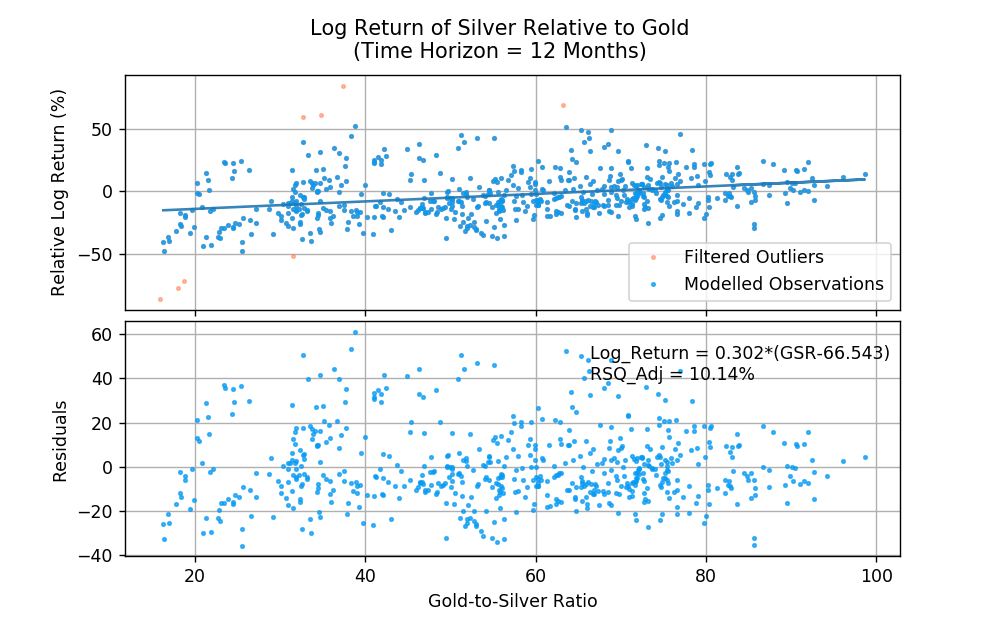

In [335]:
# Run instance
analy_GSR4 = RatioAnalysis()
analy_GSR4.read_price_dict(asset_a = ('Gold', lbma_gold_usd), asset_b = ('Silver', lbma_silver_usd),
                          asset_a_as_base=False)
analy_GSR4.compute_log_return(month_horizon=12)
analy_GSR4.run_regression(print_result=True, filt_alpha=0.005)
analy_GSR4.plot_results()

### 6 Months

                            OLS Regression Results                            
Dep. Variable:         log_return_rel   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     36.45
Date:                Wed, 26 Aug 2020   Prob (F-statistic):           2.72e-09
Time:                        20:38:58   Log-Likelihood:                -2911.8
No. Observations:                 615   AIC:                             5828.
Df Residuals:                     613   BIC:                             5836.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -23.1229      3.491     -6.

C:\Users\jiape\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


<IPython.core.display.Javascript object>


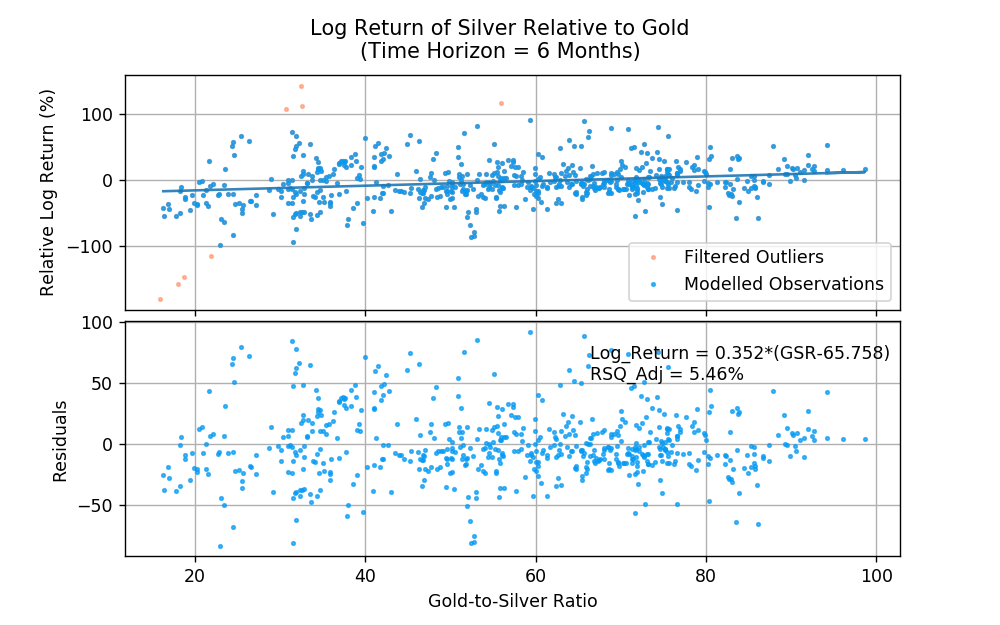

In [337]:
# Run instance
analy_GSR5 = RatioAnalysis()
analy_GSR5.read_price_dict(asset_a = ('Gold', lbma_gold_usd), asset_b = ('Silver', lbma_silver_usd),
                          asset_a_as_base=False)
analy_GSR5.compute_log_return(month_horizon=6)
analy_GSR5.run_regression(print_result=True, filt_alpha=0.005)
analy_GSR5.plot_results()